# Titanic Survival Prediction Dataset

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.


This data mining project is to determine the best form of classifier to predict passenger survival and to obtain a good score standing on **Kaggle**

* Run 1 score: 0.7742 (Top 23% on leaderboards)
* Run 2 score: 0.7856 (Top 18% on leaderboards)

##### This notebook is the third run which is my final score on the leaderboards

* Run 3 score: 0.80382 (Top 11% on leaderboards)

In [2]:
#We first import in our basic dependencies
import pandas as pd 
import numpy as np 
import sklearn as sk 
import matplotlib.pyplot as plt

In [3]:
#Load in training dataset
df = pd.read_csv('titanic_train.csv')
df_train = df.copy()
#Load in testing dataset
df_test = pd.read_csv('titanic_test.csv')

In [4]:
df_combined = pd.concat([df_train, df_test], sort=True)
df_combined
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Data Preprocessing

In [5]:
#Gender and Pclass imputation
by_sex_class = df_combined.groupby(['Sex','Pclass'])

def impute_median(series):
    return series.fillna(series.median())


df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [6]:
#Impute missing ages with the median of the age, classified by "Sex" and "Pclass"
df_combined['Age'] = by_sex_class['Age'].transform(impute_median)
#Impute "Embarked" status with the mode value
df_combined['Embarked'] = df_combined['Embarked'].fillna(df_combined['Embarked'].mode()[0])
#Drop useless variables
df_combined = df_combined.drop(['Ticket'], axis=1)
#Impute in missing "Fare" value
df_combined['Fare'] = df_combined['Fare'].fillna(df_combined['Fare'].median())

In [9]:
#Create Cabin feature
df_combined['CabinBool'] = (df_combined['Cabin'].notnull().astype('int'))
df_combined.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,CabinBool
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,0


In [10]:
#FamilySize feature, which is defined by "SibSp" and "Parch" plus the main passenger themselves
df_combined['FamilySize'] = df_combined['SibSp'] + df_combined['Parch'] + 1
df_combined['TravelAlone'] = 1

In [13]:
#Find location of variables under TravelAlone whose FamilySize > 1 and replace them with 0
df_combined['TravelAlone'].loc[df_combined['FamilySize'] > 1] = 0

/home/sauraj/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
#Name splitting
df_combined['Prefix'] = df_combined['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df_combined.Prefix

0          Mr
1         Mrs
2        Miss
3         Mrs
4          Mr
5          Mr
6          Mr
7      Master
8         Mrs
9         Mrs
10       Miss
11       Miss
12         Mr
13         Mr
14       Miss
15        Mrs
16     Master
17         Mr
18        Mrs
19        Mrs
20         Mr
21         Mr
22       Miss
23         Mr
24       Miss
25        Mrs
26         Mr
27         Mr
28       Miss
29         Mr
        ...  
388        Mr
389    Master
390        Mr
391       Mrs
392    Master
393        Mr
394        Mr
395       Mrs
396        Mr
397       Mrs
398        Mr
399        Mr
400      Miss
401        Mr
402      Miss
403        Mr
404        Mr
405        Mr
406        Mr
407        Mr
408      Miss
409      Miss
410      Miss
411       Mrs
412      Miss
413        Mr
414      Dona
415        Mr
416        Mr
417    Master
Name: Prefix, Length: 1309, dtype: object

In [16]:
#Some prefixes have a unique name to them, hence bunch them all together as "Rare" title.
for names in df_combined:
    df_combined['Prefix'] = df_combined['Prefix'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','the Countess'], 'Rare')

for names in df_combined:
    df_combined['Prefix'] = df_combined['Prefix'].replace(['Mlle'], 'Ms')

for names in df_combined:
    df_combined['Prefix'] = df_combined['Prefix'].replace(['Mme'], 'Mrs')
df_combined

df_combined.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
CabinBool      1309 non-null int64
FamilySize     1309 non-null int64
TravelAlone    1309 non-null int64
Prefix         1309 non-null object
dtypes: float64(3), int64(7), object(5)
memory usage: 163.6+ KB


In [17]:
#Make gender to 0 and 1
df_combined['Sex'] = df_combined['Sex'].astype('category')
df_combined['Sex'] = df_combined['Sex'].cat.codes

(array([1071.,  154.,   42.,    4.,   21.,   13.,    0.,    0.,    0.,
           4.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

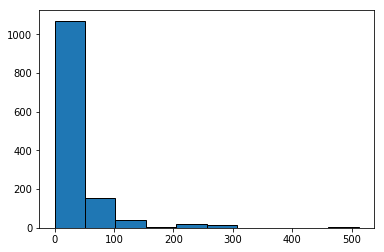

In [18]:
#Finally, remove all the useless features no longer needed
df_combined = df_combined.drop(['Name', 'Parch'], axis=1)
df_combined
plt.hist(df_combined.Fare, edgecolor='black')

In [20]:
#Categorize fare rates in four separate bins
df_combined.loc[ df_combined['Fare'] <= 7.91, 'Fare'] = 0
df_combined.loc[(df_combined['Fare'] > 7.91) & (df_combined['Fare'] <= 14.454), 'Fare'] = 1
df_combined.loc[(df_combined['Fare'] > 14.454) & (df_combined['Fare'] <= 31), 'Fare']  = 2
df_combined.loc[ df_combined['Fare'] > 31, 'Fare'] 	= 3

df_combined['Fare'] = df_combined['Fare'].astype('category')
df_combined.Fare

0      0.0
1      3.0
2      1.0
3      3.0
4      1.0
5      1.0
6      3.0
7      2.0
8      1.0
9      2.0
10     2.0
11     2.0
12     1.0
13     3.0
14     0.0
15     2.0
16     2.0
17     1.0
18     2.0
19     0.0
20     2.0
21     1.0
22     1.0
23     3.0
24     2.0
25     3.0
26     0.0
27     3.0
28     0.0
29     0.0
      ... 
388    0.0
389    2.0
390    3.0
391    3.0
392    2.0
393    1.0
394    2.0
395    3.0
396    0.0
397    3.0
398    0.0
399    0.0
400    3.0
401    2.0
402    3.0
403    3.0
404    2.0
405    1.0
406    1.0
407    3.0
408    0.0
409    1.0
410    0.0
411    3.0
412    0.0
413    1.0
414    3.0
415    0.0
416    1.0
417    2.0
Name: Fare, Length: 1309, dtype: category
Categories (4, float64): [0.0, 1.0, 2.0, 3.0]

In [21]:
#Categorize ages into five separate bins
df_combined.loc[df_combined['Age'] <= 16, 'Age'] = 0
df_combined.loc[(df_combined['Age'] > 16) & (df_combined['Age'] <= 32), 'Age'] = 1
df_combined.loc[(df_combined['Age'] > 32) & (df_combined['Age'] <= 48), 'Age'] = 2
df_combined.loc[(df_combined['Age'] > 48) & (df_combined['Age'] <= 64), 'Age'] = 3
df_combined.loc[(df_combined['Age'] > 64) ,'Age'] = 4

df_combined['Age'] = df_combined['Age'].astype('int')

In [22]:
#Categorical encoding (Method 1)
df_combined['Embarked'] = df_combined['Embarked'].astype('category')
df_combined['Embarked'] = df_combined['Embarked'].cat.codes

In [24]:
#Remove some additional features also (Drop it later if it doesn't give accurate results)
df_combined = df_combined.drop(['SibSp'], axis=1)
df_combined = df_combined.drop(['Cabin'], axis=1)

,Age,Embarked,Fare,PassengerId,Pclass,Sex,Survived,CabinBool,FamilySize,TravelAlone,Prefix
0,1,2,0.0,1,3,1,0.0,0,2,0,Mr
1,2,0,3.0,2,1,0,1.0,1,2,0,Mrs
2,1,2,1.0,3,3,0,1.0,0,1,1,Miss
3,2,2,3.0,4,1,0,1.0,1,2,0,Mrs
4,2,2,1.0,5,3,1,0.0,0,1,1,Mr
5,1,1,1.0,6,3,1,0.0,0,1,1,Mr
6,3,2,3.0,7,1,1,0.0,1,1,1,Mr
7,0,2,2.0,8,3,1,0.0,0,5,0,Master
8,1,2,1.0,9,3,0,1.0,0,3,0,Mrs
9,0,0,2.0,10,2,0,1.0,0,2,0,Mrs


In [25]:
#Columns to be converted to dummy variables
var_to_dummy = ['Prefix']
df_combined = pd.get_dummies(df_combined, columns=var_to_dummy)
df_combined

,Age,Embarked,Fare,PassengerId,Pclass,Sex,Survived,CabinBool,FamilySize,TravelAlone,Prefix_Master,Prefix_Miss,Prefix_Mr,Prefix_Mrs,Prefix_Ms,Prefix_Rare
0,1,2,0.0,1,3,1,0.0,0,2,0,0,0,1,0,0,0
1,2,0,3.0,2,1,0,1.0,1,2,0,0,0,0,1,0,0
2,1,2,1.0,3,3,0,1.0,0,1,1,0,1,0,0,0,0
3,2,2,3.0,4,1,0,1.0,1,2,0,0,0,0,1,0,0
4,2,2,1.0,5,3,1,0.0,0,1,1,0,0,1,0,0,0
5,1,1,1.0,6,3,1,0.0,0,1,1,0,0,1,0,0,0
6,3,2,3.0,7,1,1,0.0,1,1,1,0,0,1,0,0,0
7,0,2,2.0,8,3,1,0.0,0,5,0,1,0,0,0,0,0
8,1,2,1.0,9,3,0,1.0,0,3,0,0,0,0,1,0,0
9,0,0,2.0,10,2,0,1.0,0,2,0,0,0,0,1,0,0


In [26]:
df_train_processed = df_combined[:891]
df_test_processed = df_combined[892:]
df_test_processed

,Age,Embarked,Fare,PassengerId,Pclass,Sex,Survived,CabinBool,FamilySize,TravelAlone,Prefix_Master,Prefix_Miss,Prefix_Mr,Prefix_Mrs,Prefix_Ms,Prefix_Rare
1,2,2,0.0,893,3,0,NaN,0,2,0,0,0,0,1,0,0
2,3,1,1.0,894,2,1,NaN,0,1,1,0,0,1,0,0,0
3,1,2,1.0,895,3,1,NaN,0,1,1,0,0,1,0,0,0
4,1,2,1.0,896,3,0,NaN,0,3,0,0,0,0,1,0,0
5,0,2,1.0,897,3,1,NaN,0,1,1,0,0,1,0,0,0
6,1,1,0.0,898,3,0,NaN,0,1,1,0,1,0,0,0,0
7,1,2,2.0,899,2,1,NaN,0,3,0,0,0,1,0,0,0
8,1,0,0.0,900,3,0,NaN,0,1,1,0,0,0,1,0,0
9,1,2,2.0,901,3,1,NaN,0,3,0,0,0,1,0,0,0
10,1,2,0.0,902,3,1,NaN,0,1,1,0,0,1,0,0,0


In [ ]:
df_test_processed.to_csv('df_test_processed')
df_train_processed.to_csv('df_train_processed')

### Model Building

In [33]:
import pandas as pd
import sklearn as sk 
import numpy as np 
import matplotlib.pyplot as plt
import xgboost as xgb

SEED = 222
np.random.seed(SEED)

### Importing in the dataset

The dataset was already pre-processed before. Now it is time to create a strong ensemble learner using meta-stacking and averaging the predictions of all the base classifiers 


The dataset has been already pre-processed before

In [34]:
df_train = pd.read_csv('/home/sauraj/Desktop/df_train_processed.csv')
df_test = pd.read_csv('/home/sauraj/Desktop/df_test_processed.csv')

#Removing "Unnamed: 0" from both the datasets 
numerics = df_test["Unnamed: 0"]
df_train = df_train.drop(["Unnamed: 0"], axis=1)
df_test = df_test.drop(["Unnamed: 0"], axis=1)

In [35]:
#Convert few variables to "int"
df_train['Fare'] = df_train['Fare'].astype(int)
df_train['Survived'] = df_train['Survived'].astype(int)
df_test['Fare'] = df_test['Fare'].astype(int)

In [36]:
#Remove "PassengerId"
df_train = df_train.drop(["PassengerId"], axis=1)

### Train-test split of the training dataset 

Because the whole dataset cannot be used to build a training model, we first split the training dataset into a train and a validation sample, which we will used to determine the best model through cross-validation

In [37]:
from sklearn.model_selection import train_test_split

X = df_train.drop(["Survived"], axis=1)
y = df_train["Survived"]
test_data = df_test.drop(["Survived", "PassengerId"], axis=1)

passengerid = df_test["PassengerId"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

In [167]:
df_test = df_test.drop(["PassengerId"], axis=1)

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Age              891 non-null int64
Embarked         891 non-null int64
Fare             891 non-null int64
Pclass           891 non-null int64
Sex              891 non-null int64
CabinBool        891 non-null int64
FamilySize       891 non-null int64
TravelAlone      891 non-null int64
Prefix_Master    891 non-null int64
Prefix_Miss      891 non-null int64
Prefix_Mr        891 non-null int64
Prefix_Mrs       891 non-null int64
Prefix_Ms        891 non-null int64
Prefix_Rare      891 non-null int64
dtypes: int64(14)
memory usage: 97.5 KB


In [169]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 14 columns):
Age              417 non-null int64
Embarked         417 non-null int64
Fare             417 non-null int64
Pclass           417 non-null int64
Sex              417 non-null int64
CabinBool        417 non-null int64
FamilySize       417 non-null int64
TravelAlone      417 non-null int64
Prefix_Master    417 non-null int64
Prefix_Miss      417 non-null int64
Prefix_Mr        417 non-null int64
Prefix_Mrs       417 non-null int64
Prefix_Ms        417 non-null int64
Prefix_Rare      417 non-null int64
dtypes: int64(14)
memory usage: 45.7 KB


### Initial predictions using base classifiers 

Before any stacking can be performed, let's first analyze and see how the predictions appear on the dataset when the base classifiers are used individually 

In [39]:
#Importing all the classifiers needed 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#Metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

In [40]:
#Define a function "base_classifiers" which consists of all the classifiers needed for this problem 
def base_classifiers():
    
    dtree = DecisionTreeClassifier()
    bagger = BaggingClassifier()
    rf = RandomForestClassifier()
    ada = AdaBoostClassifier()
    gboost = GradientBoostingClassifier()
    logit = LogisticRegression(C=100, random_state=SEED)
    knn = KNeighborsClassifier(n_neighbors=3)
    mlp = MLPClassifier(early_stopping=False, random_state=SEED)
    gnb = GaussianNB()
    ridge = RidgeClassifier()
    
    models = {
            "bagger":bagger,
             "rf":rf,
             "ada":ada,
             "gboost":gboost,
             "logit":logit,
             "mlp":mlp,
             "gnb":gnb}
    return models


def predictor(model_list):
    data = np.zeros((y_test.shape[0], len(model_list)))
    data = pd.DataFrame(data)
    
    print("Fitting the models now...")
    cols = list()
    for i, (name, classifier) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        classifier.fit(X_train, y_train)
        data.iloc[:, i] = classifier.predict_proba(X_test)[:, 1]
        cols.append(name)
        print("Complete")
        
    data.columns = cols
    print("Done. \n")
    return data


#Scoring was done using AUC score
def score_models(data, y):
    print("Scoring models")
    for classifier in data.columns:
        score = roc_auc_score(y, data.loc[:, classifier])
        print("%-26s: %.3f" % (classifier, score))
    print("Done.\n")
    

In [41]:
models = base_classifiers()
data = predictor(models)
score_models(data, y_test)

Fitting the models now...
bagger... Complete
rf... Complete
ada... Complete
gboost... Complete
logit... Complete
mlp... 

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Complete
gnb... Complete
Done. 

Scoring models
bagger                    : 0.868
rf                        : 0.874
ada                       : 0.891
gboost                    : 0.914
logit                     : 0.895
mlp                       : 0.915
gnb                       : 0.849
Done.



## Hyperparameter Tuning 

The next step is to determine the best parameters for each form of classifier using **Exhaustive Grid Search**.

Hyperparameter tuning is the same as Model selection in regression problems, where the model is evaluated using stepwise methods and the model with the lowest AIC or smallest Cp is picked as the best model.

Here, hyperparameter tuning will be done on all the classifiers which will be fed into the base classifier.

### Classifiers which were selected
* Decision tree
* Random Forests
* AdaBoost
* GradientBoost
* Logistic Regression 
* Extra Trees
* Gaussian Naive Bayes
* Bagging 

In [42]:
#The first step is to instantiate the classifiers and pre-define
#their metrics on which the hyperparameter will be run.

dtree = DecisionTreeClassifier()
rf = RandomForestClassifier()
adaboost = AdaBoostClassifier()
gboost = GradientBoostingClassifier()
logit = LogisticRegression()
etrees = ExtraTreeClassifier()
gnb = GaussianNB()
bagger = BaggingClassifier()

#Decision tree, Random Forest, Extra trees
tree_criterion = ["gini", "entropy"]
tree_max_depth = range(1, 21)
tree_samples_split = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tree_max_features = ["auto","sqrt","log2"]
tree_oob_score = [True, False] #Random Forest 
bagger_bootstrap = [True, False]
bagger_bootstrap_features = [True, False]

#Extratrees 
etrees_criterion = ["gini", "entropy"]
etrees_max_features = ["auto","sqrt","log2"]
etrees_max_depth = range(1, 21)
etrees_boostrap = [True, False]

#AdaBoost, GradientBoost
boosting_n_estimators = [50, 100, 150, 200, 250, 300]
boosting_learning_rate = [0.001, 0.01, 0.1, 1]
boosting_max_depth = [1, 2, 3, 4, 5] #Gradient boosting only 
boosting_max_features = ["auto","sqrt","log2"] #Gradient boosting only 

#Logistic Regression
logit_penalty = ["l1", "l2"]
logit_C = range(1, 11)
logit_solver = ["newton-cg","lbfgs","liblinear","sag","saga"]


In [97]:
#Grid search for Dtree and RF 
dtree_params = {'criterion' : tree_criterion,
              'max_depth' : tree_max_depth,
              'min_samples_split' : tree_samples_split,
              'max_features' : tree_max_features}

rf_params = {'criterion' : tree_criterion,
              'max_depth' : tree_max_depth,
              'min_samples_split' : tree_samples_split}

etrees_params = {'criterion' : tree_criterion,
                'max_features' : tree_max_features,
              'max_depth' : tree_max_depth}

adaboost_params = {'n_estimators' : boosting_n_estimators,
                  'learning_rate' : boosting_learning_rate,
                  }

gboost_params = {'n_estimators' : boosting_n_estimators,
                 'learning_rate' : boosting_learning_rate,
                 'max_depth' : boosting_max_depth,
                 'max_features' : boosting_max_features}


logit_params = {'C' : logit_C}


tree_grid = GridSearchCV(dtree, dtree_params, cv=10, scoring='accuracy')
tree_grid.fit(X_train, y_train)
print("Best Decision tree parameters: ", tree_grid.best_params_)
print("Decision tree accuracy after optimization: ", tree_grid.best_score_)

forest_grid = GridSearchCV(rf, rf_params, cv=10, scoring='accuracy')
forest_grid.fit(X_train, y_train)
print("Best Random Forests parameters: ", forest_grid.best_params_)
print("Random forest accuracy after optimization: ", forest_grid.best_score_)

etrees_grid = GridSearchCV(etrees, etrees_params, cv=10, scoring='accuracy')
etrees_grid.fit(X_train, y_train)
print("Best ExtraTrees parameters: ", etrees_grid.best_params_)
print("ExtraTrees accuracy after optimization: ", etrees_grid.best_score_)

adaboost_grid = GridSearchCV(adaboost, adaboost_params, cv=10, scoring='accuracy')
adaboost_grid.fit(X_train, y_train)
print("Best Adaboost parameters: ", adaboost_grid.best_params_)
print("Adaboost accuracy after optimization: ", adaboost_grid.best_score_)

gboost_grid = GridSearchCV(gboost, gboost_params, cv=10, scoring='accuracy')
gboost_grid.fit(X_train, y_train)
print("Best GradientBoost parameters: ", gboost_grid.best_params_)
print("GradientBoost accuracy after optimization: ", gboost_grid.best_score_)

#bagger_grid = GridSearchCV(bagger, bagger_params, cv=10, scoring='accuracy')
#bagger_grid.fit(X_train, y_train)
#print("Best BaggingClassifier parameters: ", bagger_grid.best_params_)
#print("BaggingClassifier accuracy after optimization: ", bagger_grid.best_score_)

logit_grid = GridSearchCV(logit, logit_params, cv=10, scoring='accuracy')
logit_grid.fit(X_train, y_train)
print("Best LogisticRegression parameters: ", logit_grid.best_params_)
print("LogisticRegression accuracy after optimization: ", logit_grid.best_score_)


Best Decision tree parameters:  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 0.1}
Decision tree accuracy after optimization:  0.8170144462279294
Best Random Forests parameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.1}
Random forest accuracy after optimization:  0.8202247191011236
Best ExtraTrees parameters:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto'}
ExtraTrees accuracy after optimization:  0.797752808988764
Best Adaboost parameters:  {'learning_rate': 0.1, 'n_estimators': 100}
Adaboost accuracy after optimization:  0.826645264847512
Best GradientBoost parameters:  {'learning_rate': 0.1, 'max_depth': 1, 'max_features': 'auto', 'n_estimators': 150}
GradientBoost accuracy after optimization:  0.826645264847512
Best LogisticRegression parameters:  {'C': 2}
LogisticRegression accuracy after optimization:  0.8250401284109149


In [100]:
bagger.get_params().keys()

dict_keys(['base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [104]:
#Parameter tuning for Bagging classifier
bagger_params = {'n_estimators' : boosting_n_estimators,
                'bootstrap': bagger_bootstrap,
                'bootstrap_features' : bagger_bootstrap_features}

bagger_grid = GridSearchCV(bagger, bagger_params, cv=10, scoring='accuracy')
bagger_grid.fit(X_train, y_train)
print("Best BaggingClassifier parameters: ", bagger_grid.best_params_)
print("BaggingClassifier accuracy after optimization: ", bagger_grid.best_score_)


Best BaggingClassifier parameters:  {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 100}
BaggingClassifier accuracy after optimization:  0.812199036918138


In [105]:
#New updated models for training-validation dataset 
dtree2 = DecisionTreeClassifier(criterion='gini', max_depth=14, max_features='auto',min_samples_split=0.1)
rf2 = RandomForestClassifier(criterion='gini',max_depth=5, max_features='auto',min_samples_split=0.1)
etrees2 = ExtraTreeClassifier(criterion='gini',max_depth=5, max_features='auto')
adaboost2 = AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
gboost2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=1, max_features='auto', n_estimators=150)
logit2 = LogisticRegression(C=2)
bagger2 = BaggingClassifier(bootstrap=True, bootstrap_features=True, n_estimators=100)

In [43]:
#Grid search for XGBClassifier 
xgb_model = XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1], #so called `eta` value
              'max_depth': range(1, 11),
              'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], #number of trees, change it to 1000 for better results
              }

xgb_params = GridSearchCV(xgb_model, parameters, cv=10, scoring='accuracy')
xgb_params.fit(X_train, y_train)
xgb_params.best_score_

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.826645264847512

In [319]:
xgb_params.best_params_

{'learning_rate': 0.005,
 'max_depth': 3,
 'n_estimators': 400,
 'nthread': 4,
 'objective': 'binary:logistic'}

## Stacking 

Stacking is an ensemble method which works by performing 2-fold predictions. 

* On the first fold, a group of classifiers are clumped into an ensemble of "Base classifiers". Each classifier in the base classifier is fed in the training data and their outputs are stored.

* The outputs of the Base classifier become the new training dataset for the second fold classifier, the "Final classifier" and the final classifier produces the output predictions which is much more accurate than the base classifiers.

Stacking works because it tries to improve the models in areas where the classifiers arent performing well. In this model, Decision trees and Logistic Regression performed very well at certain places where Adaboost and Bagging failed to perform that well. Stacking will take the strong classification areas of all the classifiers in the base ensemble, and produce an enriched classifier which will outperform each individual classifier.

In [170]:
#Base level models to see the performance on the model 
from vecstack import stacking
models = [dtree2, rf2, etrees2, adaboost2, gboost2, logit2, bagger2]

S_train, S_test = stacking(models, X_test, y_test, X_train, regression=False,
                          mode='oof_pred_bag',
                          needs_proba=False,
                          save_dir=None,
                          metric=accuracy_score,
                          n_folds=10,
                          stratified=True,
                          shuffle=False,
                          random_state=0,
                          verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [7]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.71428571]
    fold  1:  [0.67857143]
    fold  2:  [0.81481481]
    fold  3:  [0.88888889]
    fold  4:  [0.74074074]
    fold  5:  [0.81481481]
    fold  6:  [0.73076923]
    fold  7:  [0.84615385]
    fold  8:  [0.92307692]
    fold  9:  [0.73076923]
    ----
    MEAN:     [0.78828856] + [0.07709476]
    FULL:     [0.78731343]

model  1:     [RandomForestClassifier]
    fold  0:  [0.82142857]
    fold  1:  [0.71428571]
    fold  2:  [0.74074074]
    fold  3:  [0.92592593]
    fold  4:  [0.81481481]
    fold  5:  [0.81481481]
    fold  6:  [0.80769231]
    fold  7:  [0.84615385]
    fold  8:  [0.76923077]
    fold  9:  [0.80769231]
    ----
    MEAN:     [0.80627798] + [0.05514999]
    FULL:     [0.80597015]

model  2:     [ExtraTreeClassifier]
    fold  0:  [0.78571429]
    fold  1:  [0.71428571]
    fo

## Final learner: XGBoost

All the predictions taken from the base classifiers above will now be fed into XGBoost and the predictions will be produced out.

In [206]:
from mlens.ensemble import SuperLearner
ensemble = SuperLearner(scorer=accuracy_score, verbose=2)
ensemble.add([dtree2, rf2, adaboost2, gboost2, etrees2, logit2, bagger2])
ensemble.add_meta(xgb_model)

ensemble.fit(X, y)
predictions = ensemble.predict(test_data)


Fitting 2 layers
Processing layer-1             

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backe

done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:01

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [208]:
predictions

array([1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0.

In [211]:
output = pd.DataFrame({'PassengerId':passengerid, 'Survived':predictions})
output.to_csv('submission92.csv')

# Conclusion

The first run I had on the dataset was with using logistic regression after variable selection and data preprocessing, giving me an accuracy hit of 0.7742. Round 2 was more involved in determining a better understanding of various tree-based and ensemble classifiers like decision trees, bagging, boosting and random forests so that these can be implemented and checked how they perform in comparison to something as simple as logistic regression, htting an accuracy score of 0.7856

The dataset is fairly easy to work around if simple patters can be recognized in it. One of the problems which can be faced when running cross-validation here is that **data leakage** became a significant problem during my second trial since I made the mistake of running cross-validation on the whole of training set and not partition it into training and validation. Due to the fact that the cross-validation models gave me a cross validated score from the whole of the training dataset, it was hard to exactly judge how it would perform on a real out-of-sample dataset since I did not check my model on anything except the **actual test set**. So one thing to remember when working on this dataset is to do a **Train-test split** on the actual training dataset, cross validate on the training split and evalute the models on the testing split. Once thats done, use your actual testing set to do the final predicitons.
